In [1]:
import math
import random
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm

import numpy as np
import numba
import numpy.random
from collections import deque

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, Reshape
from tensorflow.keras.optimizers import Adam

In [2]:
class GridWorld:
    def __init__(self, taille=[4, 4], position_start=[0, 1], good_end_position=[3, 2], bad_end_position=[0, 3]):
        self.current_state = position_start  # État actuel (ligne, colonne)
        self.states = [[x, y] for x in range(taille[0]) for y in range(taille[1])]
        self.end_good_state = good_end_position  # État final (ligne, colonne)
        self.end_bad_state = bad_end_position
        self.grid_size = taille  # Taille de la grille (lignes, colonnes)
        self.stateSpace = {}
        self.matchStates()
        self.currentIntState = self.getStateInt(self.current_state)
        self.num_actions = 4  # Nombre total d'actions possibles (haut, bas, gauche, droite)
        self.reward = 0  # Récompense actuelle
        self.done = False  # Indique si la partie est terminée
        self.generate_grid()
        self.actions = [0, 1, 2, 3]
        self.rewards = [0, 1, 3]
        self.actionSpace = {0: -self.grid_size[0], 1: self.grid_size[0],
                            2: -1, 3: 1}

    def state_description(self):
        return np.array([self.currentIntState / (len(self.states) - 1) * 2.0 - 1.0])

    def state_dim(self):
        return len(self.state_description())

    def reset(self):
        self.done = False
        self.current_state = [np.random.randint(0, self.grid_size[0] - 1), np.random.randint(0, self.grid_size[1] - 1)]
        self.currentIntState = self.getStateInt(self.current_state)
        self.reward = 0

    def matchStates(self):
        i = 0
        for s in self.states:
            self.stateSpace[str(s)] = i
            i = i + 1

    def getStateInt(self, st):
        return self.stateSpace[str(st)]

    def getStateCouple(self, st):
        n_state = {i for i in self.stateSpace if self.stateSpace[i] == st}
        return list(n_state)

    def step(self, action):
        if action == 0:
            if self.current_state[0] == 0:
                self.current_state[0] = self.grid_size[0] - 1
                self.currentIntState = self.getStateInt(self.current_state)
                self.reward = 0  # Pas de récompense pour traverser le mur
                self.generate_grid()
                self.endgame()
            else:
                self.current_state[0] = self.current_state[0] - 1
                self.currentIntState = self.getStateInt(self.current_state)
                self.reward = 0  # Pas de récompense pour avancer
                self.generate_grid()
                self.endgame()

        elif action == 1:
            if self.current_state[0] == self.grid_size[0] - 1:
                self.current_state[0] = 0
                self.currentIntState = self.getStateInt(self.current_state)
                self.reward = 0  # Pas de récompense pour avancer
                self.generate_grid()
                self.endgame()
            else:
                self.current_state[0] = self.current_state[0] + 1
                self.currentIntState = self.getStateInt(self.current_state)
                self.reward = 0  # Pas de récompense pour avancer
                self.generate_grid()
                self.endgame()

        elif action == 2:
            if self.current_state[1] == 0:
                self.current_state[1] = self.grid_size[1] - 1
                self.currentIntState = self.getStateInt(self.current_state)
                self.reward = 0  # Pas de récompense pour avancer
                self.generate_grid()
                self.endgame()
            else:
                self.current_state[1] = self.current_state[1] - 1
                self.currentIntState = self.getStateInt(self.current_state)
                self.reward = 0  # Pas de récompense pour avancer
                self.generate_grid()
                self.endgame()

        elif action == 3:
            if self.current_state[1] == self.grid_size[1] - 1:
                self.current_state[1] = 0
                self.currentIntState = self.getStateInt(self.current_state)
                # print(self.current_state)
                self.reward = 0  # Pas de récompense pour avancer
                self.generate_grid()
                self.endgame()
            else:
                self.current_state[1] = self.current_state[1] + 1
                self.currentIntState = self.getStateInt(self.current_state)
                self.reward = 0  # Pas de récompense pour avancer
                self.generate_grid()
                self.endgame()
                # Si l'on atteint l'état final, la partie est terminée
        return self.currentIntState, self.reward, self.done

    def endgame(self):
        if self.current_state == self.end_good_state:
            self.reward = 10  # Récompense de 10 pour atteindre l'état final
            self.done = True
            print("Une bonne récompense")
        elif self.current_state == self.end_bad_state:
            self.reward = -10
            self.done = True
            print("Une mauvaise récompense")

    def generate_grid(self):
        grid = []
        for i in range(self.grid_size[0]):
            grid.append([])
            for j in range(self.grid_size[1]):
                grid[i].append("_")
        grid[self.current_state[0]][self.current_state[1]] = "X"
        for i in grid:
            print(i)
        print("\n")

In [3]:
def build_compile_model(env):
    model = tf.keras.models.Sequential()
    model.add(Dense(24, input_dim=1, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(len(env.actions), activation='linear'))

    model.compile(loss='mse', optimizer=Adam(learning_rate=0.01))
    return model

In [8]:
def dqn(env, max_iter=1000, gamma=0.99, alpha=0.1, epsilon=0.1):
    q_network = build_compile_model(env)
    nb_steps = 0
    first_episode = True
    
    step = 0
    reward = 0
    reward_per_episode = []
    step_by_episode = []
    
    for iteration in range(max_iter):
        print(iteration)
        if env.done:
            reward_per_episode.append(env.reward)
            step_by_episode.append(step)
            env.reset()
            step = 0
            cumumated_reward = 0
            
        actions = env.actions
        current_state = env.currentIntState
        q_values = q_network.predict(np.array([current_state]))[0]
        if np.random.rand() < epsilon:
            a = np.random.choice(actions)
        else:
            a= np.argmax(q_values)

        old_reward = env.reward
        new_state, reward, done = env.step(a)
        print(done)

        q_values[a] = reward + gamma * np.amax(q_network.predict(np.array([new_state]))[0])
        q_network.fit(np.array([current_state]), np.array([q_values]), verbose=0)
        current_state = new_state
            
        step += 1

    return reward_per_episode, step_by_episode

['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


0
1/1 [==============================] - 0s 110ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


False
1/1 [==============================] - 0s 31ms/step
1
1/1 [==============================] - 0s 31ms/step
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 52ms/step
2
1/1 [==============================] - 0s 40ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['

1/1 [==============================] - 0s 47ms/step
27
1/1 [==============================] - 0s 38ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


False
1/1 [==============================] - 0s 68ms/step
28
1/1 [==============================] - 0s 38ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


False
1/1 [==============================] - 0s 37ms/step
29
1/1 [==============================] - 0s 40ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


False
1/1 [==============================] - 0s 40ms/step
30
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 48ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


False
1/1 [==============================] - 0s 45ms/step
55
1/1 [==============================] - 0s 45ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']


False
1/1 [==============================] - 0s 45ms/step
56
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


False
1/1 [==============================] - 0s 38ms/step
57
1/1 [==============================] - 0s 33ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_'

1/1 [==============================] - 0s 41ms/step
82
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']


False
1/1 [==============================] - 0s 35ms/step
83
1/1 [==============================] - 0s 43ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


False
1/1 [==============================] - 0s 52ms/step
84
1/1 [==============================] - 0s 40ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 35ms/step
85
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 49ms/step
109
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 43ms/step
110
1/1 [==============================] - 0s 42ms/step
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 43ms/step
111
1/1 [==============================] - 0s 44ms/step
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 41ms/step
112
1/1 [==============================] -

1/1 [==============================] - 0s 36ms/step
136
1/1 [==============================] - 0s 51ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 47ms/step
137
1/1 [==============================] - 0s 40ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 40ms/step
138
1/1 [==============================] - 0s 44ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']


False
1/1 [==============================] - 0s 39ms/step
139
1/1 [==============================] -

1/1 [==============================] - 0s 44ms/step
163
1/1 [==============================] - 0s 43ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 41ms/step
164
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 42ms/step
165
1/1 [==============================] - 0s 43ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 37ms/step
166
1/1 [==============================] -

1/1 [==============================] - 0s 34ms/step
190
1/1 [==============================] - 0s 33ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 34ms/step
191
1/1 [==============================] - 0s 35ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 43ms/step
192
1/1 [==============================] - 0s 48ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 49ms/step
193
1/1 [==============================] -

1/1 [==============================] - 0s 49ms/step
217
1/1 [==============================] - 0s 42ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 45ms/step
218
1/1 [==============================] - 0s 36ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 36ms/step
219
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


Une bonne récompense
True
1/1 [==============================] - 0s 43ms/step
220
1/1 [=============

1/1 [==============================] - 0s 41ms/step
244
1/1 [==============================] - 0s 36ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 44ms/step
245
1/1 [==============================] - 0s 42ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 41ms/step
246
1/1 [==============================] - 0s 40ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 40ms/step
247
1/1 [==============================] -

1/1 [==============================] - 0s 41ms/step
271
1/1 [==============================] - 0s 43ms/step
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 43ms/step
272
1/1 [==============================] - 0s 46ms/step
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 37ms/step
273
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 45ms/step
274
1/1 [==============================] -

1/1 [==============================] - 0s 37ms/step
298
1/1 [==============================] - 0s 41ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 51ms/step
299
1/1 [==============================] - 0s 46ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 38ms/step
300
1/1 [==============================] - 0s 37ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 38ms/step
301
1/1 [==============================] -

1/1 [==============================] - 0s 64ms/step
325
1/1 [==============================] - 0s 48ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 60ms/step
326
1/1 [==============================] - 0s 38ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 54ms/step
327
1/1 [==============================] - 0s 41ms/step
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 36ms/step
328
1/1 [==============================] -

1/1 [==============================] - 0s 52ms/step
352
1/1 [==============================] - 0s 49ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 39ms/step
353
1/1 [==============================] - 0s 47ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 33ms/step
354
1/1 [==============================] - 0s 33ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 46ms/step
355
1/1 [==============================] -

1/1 [==============================] - 0s 36ms/step
379
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', 'X', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 39ms/step
380
1/1 [==============================] - 0s 40ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', 'X', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 48ms/step
381
1/1 [==============================] - 0s 42ms/step
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 42ms/step
382
1/1 [==============================] -

1/1 [==============================] - 0s 43ms/step
406
1/1 [==============================] - 0s 42ms/step
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 39ms/step
407
1/1 [==============================] - 0s 38ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 42ms/step
408
1/1 [==============================] - 0s 51ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 57ms/step
409
1/1 [==============================] -

1/1 [==============================] - 0s 39ms/step
433
1/1 [==============================] - 0s 44ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 40ms/step
434
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 39ms/step
435
1/1 [==============================] - 0s 39ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', 'X', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 35ms/step
436
1/1 [==============================] -

1/1 [==============================] - 0s 58ms/step
460
1/1 [==============================] - 0s 41ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 47ms/step
461
1/1 [==============================] - 0s 38ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 41ms/step
462
1/1 [==============================] - 0s 38ms/step
['_', 'X', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 38ms/step
463
1/1 [==============================] -

1/1 [==============================] - 0s 44ms/step
487
1/1 [==============================] - 0s 49ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', 'X', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 48ms/step
488
1/1 [==============================] - 0s 47ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['X', '_', '_', '_', '_', '_']


False
1/1 [==============================] - 0s 45ms/step
489
1/1 [==============================] - 0s 47ms/step
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'X']


False
1/1 [==============================] - 0s 46ms/step
490
1/1 [==============================] -

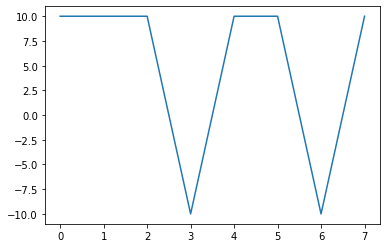

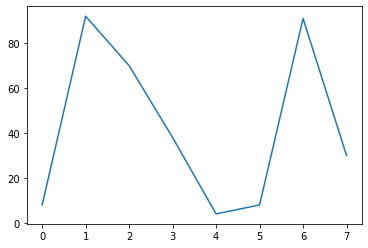

In [9]:
if __name__ == '__main__':
    world = GridWorld()
    #For 1000
    scores, steps = dqn(world, max_iter = 1000)
    plt.plot(scores)
    plt.show()
    plt.plot(steps)
    plt.show()
    
    #For 10000
    scores, steps = dqn(world, max_iter = 10000)
    plt.plot(scores)
    plt.show()
    plt.plot(steps)
    plt.show()